# Recruit Restaurant Visitor Forecasting

Predict how many future visitors a restaurant will receive

## Introduction 

미래의 식당 고객 예측 (time series forecasting) 

일본 2개의 웹사이트에서 나온 8개의 파일로 이루어진 일식당 데이터 
* Hot Pepper Gourment (hpg) : similar to Yelp, here users can search restaurants and also make a reservation online
* AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

Train data set : 01/2016 ~ 04/2017
* 식당이 열지 않은 날은 제외 
<br>

Test data set : 04/2016 ~ 05/2016 
* __public, private 순서이고 "Gloden Week"이 포함된 주__
* 식당이 열지않아 손님이 없는 날은 점수 산정에서 제외 

8개의 파일 

__air_reserve.csv & hpg_reserve.csv__

: air & hpg 레스토랑 예약 시스템
* `air_store_id` or `hpg_store_id` - the restaurant's id in the air system
* `visit_datetime` - the time of the reservation
* `reserve_datetime` - the time the reservation was made
* `reserve_visitors` - the number of visitors for that reservation

__air_store_info.csv & hpg_store_info.csv__
: air & hpg 레스토랑 세부 정보
* `air_store_id` & `hpg_store_id`
* `air_genre_name`
* `air_area_name`
* `latitude`
* `longitude`

__store_id_relation.csv__
: air & hpg id

__date_info.csv__
: 일본 공휴일 정보

__sample_submission.csv__
: test set으로 사용. ’id’는 `air_store_id`와 `visit_date`를 결합하여 생성

__date_info.csv__
: This file gives basic information about the calendar dates in the dataset.
* `calendar_date`
* `day_of_week`
* `holiday_flg` : is the day a holiday in Japan

File Descriptions
This is a relational dataset from two systems. Each file is prefaced with the source (either air_ or hpg_) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

### Read files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt


In [ ]:
air_visit = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/air_visit_data.csv')
air_reserve = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/air_reserve.csv')
hpg_reserve  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/hpg_reserve.csv')
air_store = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/air_store_info.csv')
hpg_store  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/hpg_store_info.csv')
holidays  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/date_info.csv')
store_ids  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/store_id_relation.csv')
test  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/sample_submission.csv')

In [ ]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [ ]:
air_visit['day'] = pd.to_datetime(air_visit['visit_date'])
air_visit['day'] = air_visit['day'].dt.day_name()

air_visit['month'] = pd.to_datetime(air_visit['visit_date'])
air_visit['month'] = air_visit['month'].dt.month_name()

air_visit.head()

,air_store_id,visit_date,visitors,day,month
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,January
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,January
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,January
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,January
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,January


In [ ]:
air_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211306 entries, 0 to 211305
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  211306 non-null  object
 1   visit_date    211306 non-null  object
 2   visitors      211306 non-null  int64 
 3   day           211306 non-null  object
 4   month         211306 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.1+ MB


Text(0.5, 1.0, 'Air Visits')

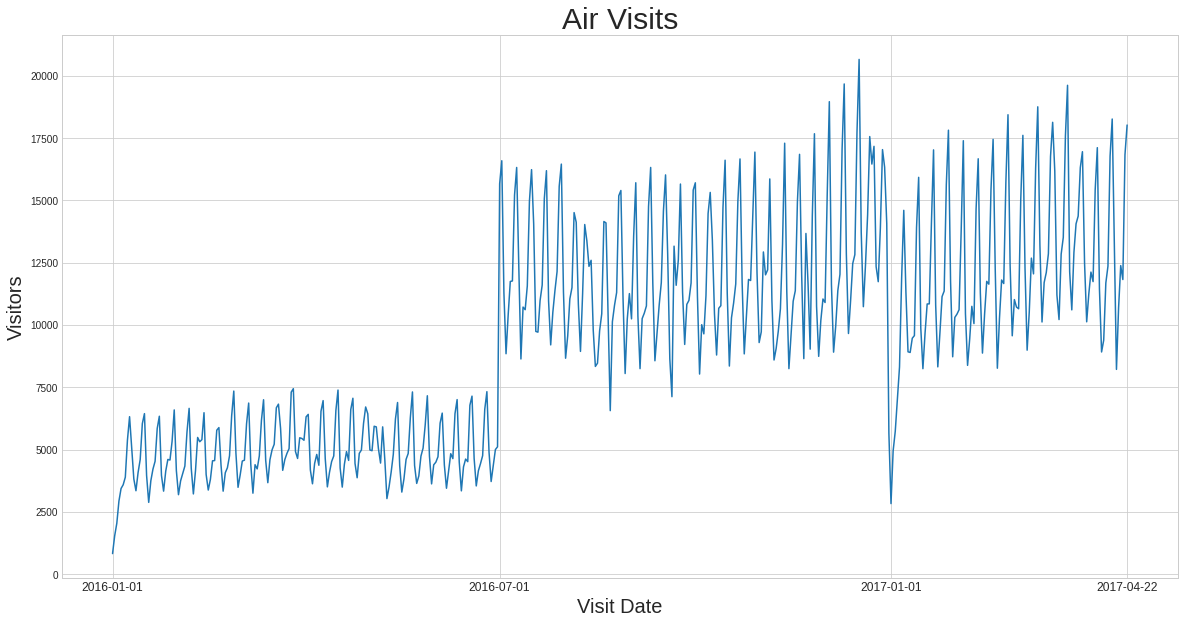

In [ ]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
tick  = ax.set_xticks([0, 182, 366, 477])
labels = ax.set_xticklabels(['2016-01-01', '2016-07-01','2017-01-01', '2017-04-22'], fontsize='large')
air_visit.groupby(['visit_date'])['visitors'].sum().plot()
plt.xlabel('Visit Date', fontsize = 20)
plt.ylabel('Visitors', fontsize = 20)
plt.title('Air Visits', fontsize = 30)

Text(0, 0.5, 'Visitors')

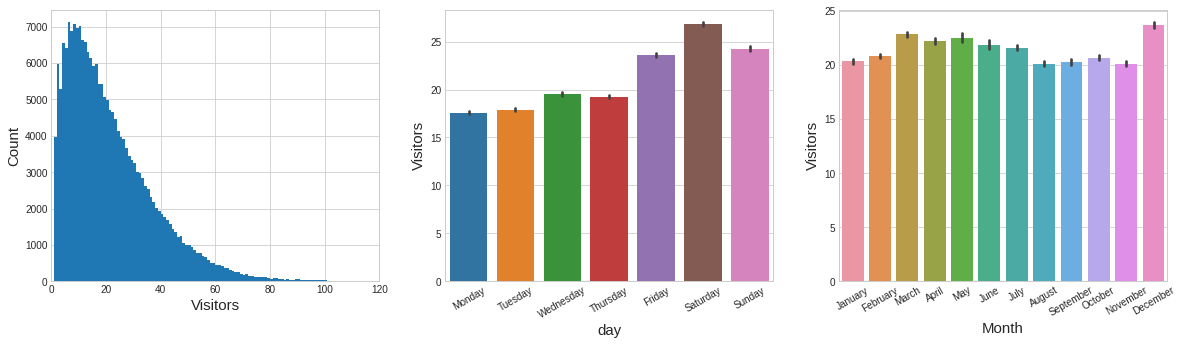

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(air_visit['visitors'], bins = range(1, 200, 1))
plt.xlim([0, 120])
plt.xlabel('Visitors',fontsize = 15)
plt.ylabel('Count',fontsize = 15)

plt.subplot(1, 3, 2)
sns.barplot(data = air_visit, 
            x = 'day', y = 'visitors', 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=30)
plt.xlabel('day',fontsize = 15)
plt.ylabel('Visitors',fontsize = 15)

plt.subplot(1, 3, 3)
sns.barplot(data = air_visit, 
            x = 'month', y = 'visitors')
plt.xticks(rotation=30)
plt.xlabel('Month',fontsize = 15)
plt.ylabel('Visitors',fontsize = 15)

#### __air_reserve__

There were much fewer reservations made in 2016 through the air system even none at all for a long stretch of time.

The volume only __increased during the end of 2016__ and the visior numbers __stayed strong in 2017__.

Here, the time between making a reservation and visiting the restaurant follow a __24-hour pattern__.

Very long time gaps between reservation and visit are not uncommon. (the restaurants are either fancy places, or there numbers are a result of a data imput error and got mixed up)

In [ ]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [ ]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [ ]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].apply(lambda x : str(x[:10]))
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01


Text(0.5, 1.0, 'Air Visits')

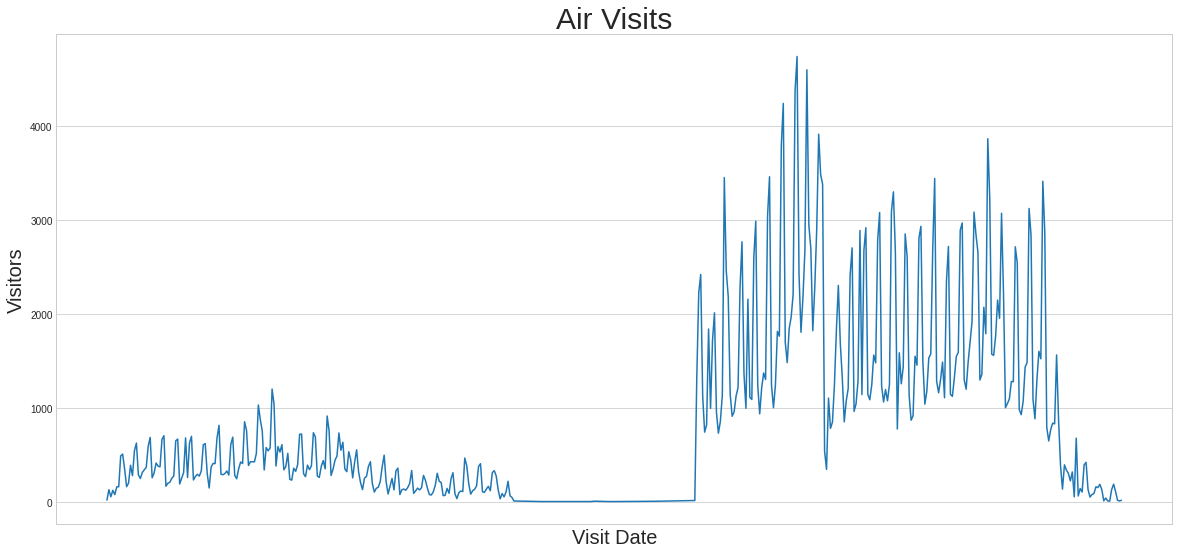

In [ ]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
tick  = ax.set_xticks([0, 182, 366, 477])
labels = ax.set_xticklabels(['2016-01-01', '2016-07-01','2017-01-01', '2017-04-22'], fontsize='large')
air_reserve.groupby(['visit_date'])['reserve_visitors'].sum().plot()
plt.xlabel('Visit Date', fontsize = 20)
plt.ylabel('Visitors', fontsize = 20)
plt.title('Air Reservation', fontsize = 30)

#### __air_store__
Here are lots of _Izakaya gastropubs_, followed by _Cafe's_


In [ ]:
air_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


#### hpg_reserve

In [ ]:
hpg_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116340 entries, 0 to 116339
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   hpg_store_id      116340 non-null  object 
 1   visit_datetime    116339 non-null  object 
 2   reserve_datetime  116339 non-null  object 
 3   reserve_visitors  116339 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.6+ MB


#### hpg_store

In [ ]:
hpg_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hpg_store_id    4690 non-null   object 
 1   hpg_genre_name  4690 non-null   object 
 2   hpg_area_name   4690 non-null   object 
 3   latitude        4690 non-null   float64
 4   longitude       4690 non-null   float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


#### holidays

In [ ]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   calendar_date  517 non-null    object
 1   day_of_week    517 non-null    object
 2   holiday_flg    517 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.2+ KB


#### store_ids

In [ ]:
store_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   air_store_id  150 non-null    object
 1   hpg_store_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32019 non-null  object
 1   visitors  32019 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.4+ KB
